Shape of X: (1000, 2)
Shape of y: (1000,)


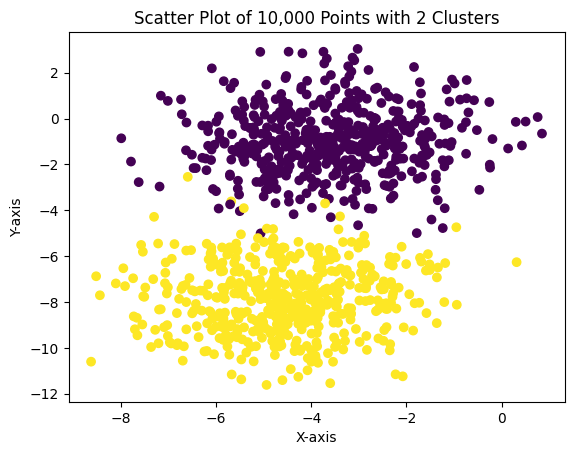

In [46]:
import numpy as np
import scipy
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
OUTPUT_STEP = 0.1
N_SAMPLES = 1000
PARTITION = int(N_SAMPLES*0.1)

# Set random seed for reproducibility
np.random.seed(420)

# Create dataset with 10,000 points and 2 clusters
X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)

# Print the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Create scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y)

# Add axis labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

# Show the plot
plt.show()


In [47]:
import collections

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

unlabeled_X.shape

# Label initialization
y_labeled = np.array(y[:PARTITION])
collections.Counter(y_labeled)

y_unlabeled_target = np.array(y[PARTITION:])

y_unlabeled_initial = np.random.choice([0,1], size = (len(unlabeled_X,)))

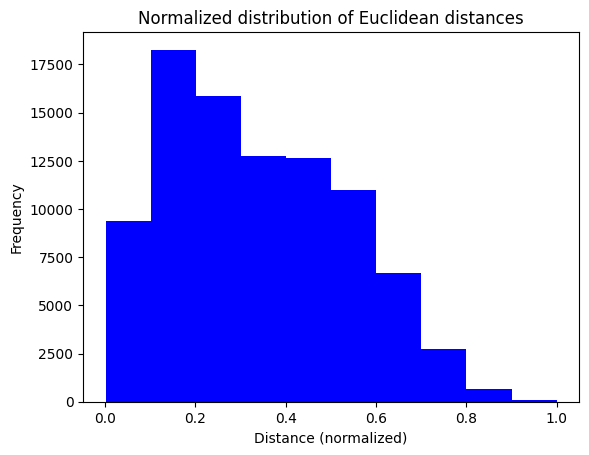

(100, 900)

In [48]:
import math
import seaborn as sns

labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

len(labeled_distances[0])

labeled_dist_matrix = np.array(labeled_distances)

labeled_dist_matrix.shape

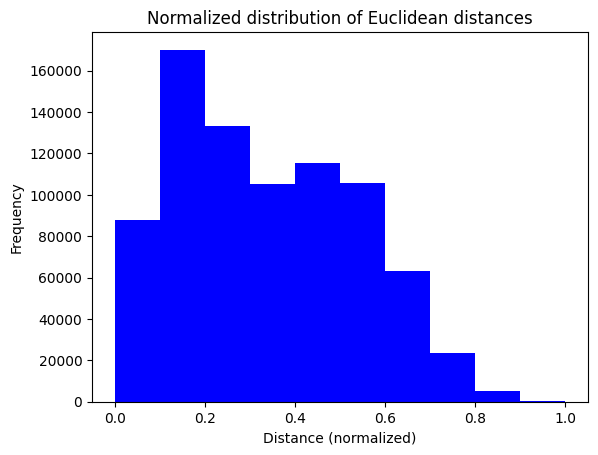

(900, 900)

In [49]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

unlabeled_distances.shape


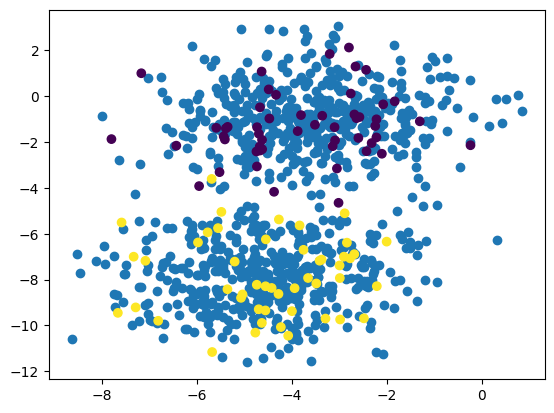

In [50]:
plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=new_y)

plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [51]:
def weight(dist):
    return math.e**(-10*dist**2)

In [52]:
%%time
print("Calculating weights between labeled points and unlabeled points")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
print('Done')

print("Calculating weights between unlabeled points and unlabeled points")
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Calculating weights between labeled points and unlabeled points
Done
Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 404 ms, sys: 26.6 ms, total: 431 ms
Wall time: 432 ms


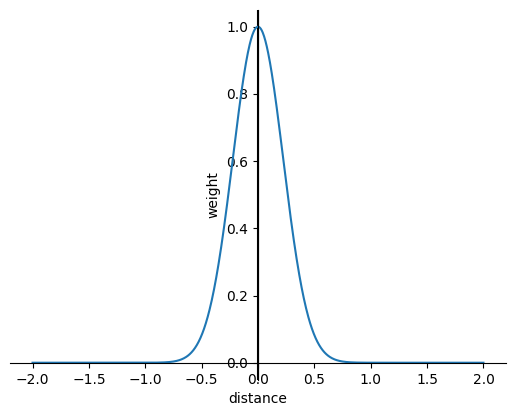

In [53]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [54]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w_labeled_unlabeled.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_unlabeled_unlabeled.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [55]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(labeled_unlabeled_weights) * 4 + np.sum(unlabeled_unlabeled_weights) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=2)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=2)
    return 1 - current_distance / initial_distance

def accuracy(current):
    return accuracy_round(current) #loss(y_labeled, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [56]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 83.58789834997327,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 576.3670820923351
Estimating Lipschitz constant for each single variable
Done
CPU times: user 869 ms, sys: 1.32 s, total: 2.19 s
Wall time: 436 ms
